In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
from numpy.typing import NDArray
import skimage
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
import numpy as np

def image_interpolate2d(image: NDArray, ratio: int, kernel: callable) -> NDArray:
    """
    Interpolate image using 2D kernel interpolation
    :param image: grayscale image to interpolate as 2D NDArray
    :param ratio: up-scaling factor
    :return: interpolated image as 2D NDArray
    """
    w = 1
    input_shape = image.shape
    target_shape = [input_shape[0] * ratio, input_shape[1] * ratio]

    image_grid = np.array([(i, j) for i in range(input_shape[0]) for j in range(input_shape[1])])
    interpolate_grid = np.array([(i / ratio, j / ratio) for i in range(target_shape[0]) for j in range(target_shape[1])])

    kernels = []

    for point, value in zip(image_grid, image.ravel()):
        kernel_values = value * kernel(interpolate_grid, offset=point, width = w)
        kernels.append(kernel_values.reshape(target_shape))

    return np.sum(np.asarray(kernels), axis=0)

def sample_hold_kernel2d(x: NDArray, offset: float, width: float) -> NDArray:
    x = x - offset
    x_coords, y_coords = x[:, 0], x[:, 1]
    return ((x_coords >= 0) & (x_coords < width) & (y_coords >= 0) & (y_coords < width)).astype(float)

def nearest_neighbor_kernel2d(x: NDArray, offset: float, width: float) -> NDArray:
    x = x - offset
    x_coords, y_coords = x[:, 0], x[:, 1]
    return ((x_coords >= (-width/2)) & (x_coords < (width/2)) & (y_coords >= (-width/2)) & (y_coords < (width/2))).astype(float)

def linear_kernel2d(x: NDArray, offset: float, width: float) -> NDArray:
    x = x - offset
    x_coords, y_coords = x[:, 0], x[:, 1]
    return (1 - np.abs(x_coords)) * (1 - np.abs(y_coords)) * ((np.abs(x_coords) < width) & (np.abs(x_coords) > -width))  * ((np.abs(y_coords) < width) & (np.abs(y_coords) > -width))

In [4]:
def convolution(data, kernel, kernel_size, step, padding = 0):
    result = []
    for i in range(0, len(data) - kernel_size, step):
        temp = []
        for j in range(0, len(data[0]) - kernel_size, step):
            if (i < (len(data)) - 1 and j < len(data[0]) - 1):
                temp.append(kernel((data[i:i+kernel_size,j:j+kernel_size]), kernel_size))
        result.append(temp)
    return np.array(result)

def mean_kernel(data, matrix_size):
  sum = 0
  matrix = np.array([[1] * matrix_size] * matrix_size)
  for i in range(matrix_size):
    for j in range(matrix_size):
      sum += data[i][j] * matrix[i][j]
  return np.divide(sum, np.power(matrix_size, 2))

In [5]:
image_circle_from_file = np.asarray(Image.open('/content/drive/MyDrive/image.png'))
camera_grayscale = skimage.data.camera()

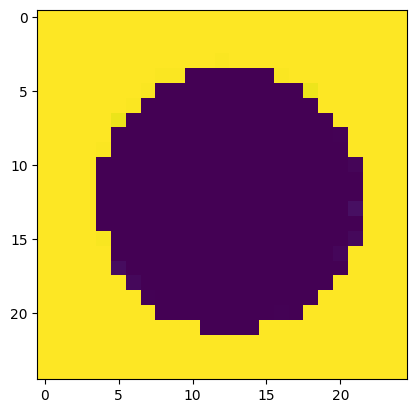

In [6]:
image_circle = convolution(image_circle_from_file, mean_kernel, 1, 16)
plt.imshow(image_circle)
plt.show()

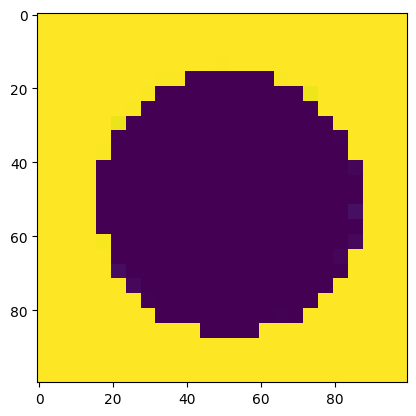

In [7]:
plt.imshow(image_interpolate2d(image_circle, 4, sample_hold_kernel2d))

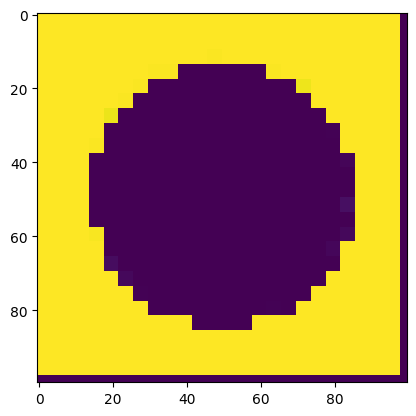

In [8]:
plt.imshow(image_interpolate2d(image_circle, 4, nearest_neighbor_kernel2d))

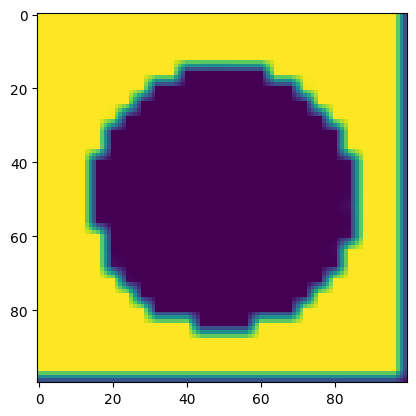

In [9]:
plt.imshow(image_interpolate2d(image_circle, 4, linear_kernel2d))

In [10]:
sample_array = np.asarray([[1,2,3], [4,5,6],[7,8,9],[10,11,12]])

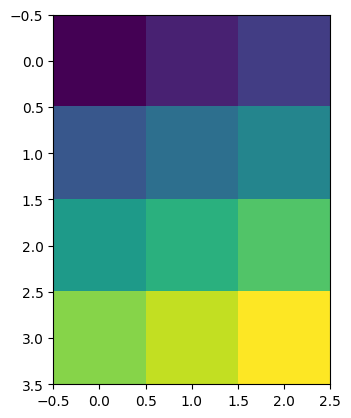

In [11]:
plt.imshow(sample_array)

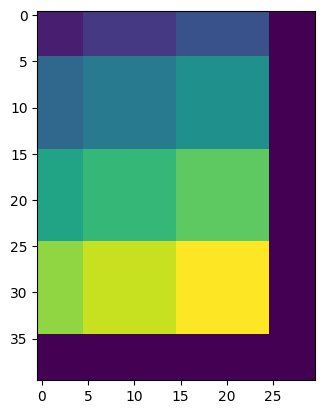

In [12]:
plt.imshow(image_interpolate2d(sample_array, 10, nearest_neighbor_kernel2d))

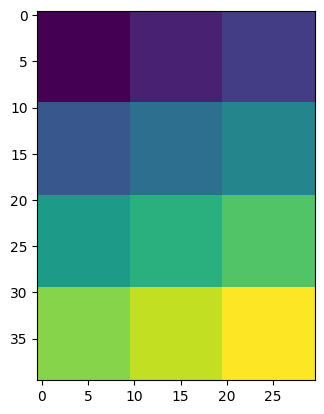

In [13]:
plt.imshow(image_interpolate2d(sample_array, 10, sample_hold_kernel2d))

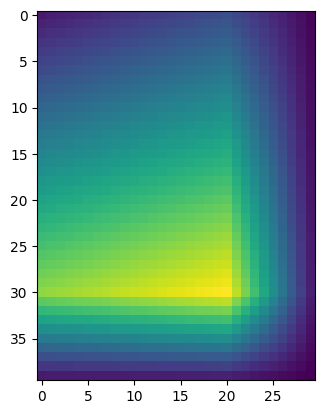

In [14]:
plt.imshow(image_interpolate2d(sample_array, 10, linear_kernel2d))